# PyGrunn - `vaex` - Machine Learning example: creating the model pipeline

In [1]:
import vaex
import vaex.ml

import numpy
import pylab as p
import pylab as np

### Read in the data

In [2]:
# Read the data
df = vaex.open('./data/yellow_taxi_2013_mini.hdf5')
print('This dataset has %i samples.' % len(df))

This dataset has 5000000 samples.


### Train / test split

In [3]:
# Split the data into train test split
train, test = df.ml.train_test_split(verbose=False)

print('Training set')
display(train.head(3))
print('Test set')
display(test.head(3))

Training set


#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2013-01-01 12:26:00.000000000,2013-01-01 12:38:00.000000000,6,0.1,-73.9413,40.6846,1,nan,-73.9415,40.685,CSH,8,0,0.5,0,0,8.5
1,VTS,2013-01-01 12:26:00.000000000,2013-01-01 12:37:00.000000000,1,2.49,-73.9717,40.7463,1,nan,-73.9785,40.7764,CRD,10.5,0,0.5,2.1,0,13.1
2,VTS,2013-01-01 12:31:00.000000000,2013-01-01 12:36:00.000000000,1,0.92,-73.9809,40.7643,1,nan,-73.9683,40.7625,CSH,5.5,0,0.5,0,0,6


Test set


#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2013-01-01 15:11:48.000000000,2013-01-01 15:18:10.000000000,4,1,-73.9782,40.758,1,0,-73.9898,40.7512,CSH,6.5,0,0.5,0,0,7
1,CMT,2013-01-06 00:18:35.000000000,2013-01-06 00:22:54.000000000,1,1.5,-74.0067,40.7318,1,0,-73.9945,40.7507,CSH,6,0.5,0.5,0,0,7
2,CMT,2013-01-05 18:49:41.000000000,2013-01-05 18:54:23.000000000,1,1.1,-74.0047,40.7378,1,0,-74.0098,40.726,CSH,5.5,1,0.5,0,0,7


### Save the test set for later use

In [4]:
test.export_arrow('./data/test_set.arrow')

## Let's build a pipeline!

In [5]:
train.describe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
dtype,str,datetime64[ns],datetime64[ns],int64,float64,float64,float64,float64,float64,float64,float64,str,float64,float64,float64,float64,float64,float64
count,4000000,4000000,4000000,4000000,4000000,4000000,4000000,4000000,2563581,3999962,3999962,4000000,4000000,4000000,4000000,4000000,4000000,4000000
missing,0,0,0,0,0,0,0,0,1436419,38,38,0,0,0,0,0,0,0
mean,--,1970-01-01T00:09:00.349444049,1970-01-01T00:20:37.415402549,1,2.958016705000041,-72.64137000953588,40.014031298022054,1.04123125,0.017200938842970047,-72.62597349457002,40.007532765198626,--,12.190607450000012,0.31715185749999997,0.497693625,1.881193305001449,0.2352681699998299,15.121914407494007
std,--,5.19899e+14,5.19925e+14,1.2146,3.44064,9.93951,7.30636,0.356967,0.130019,10.119,6.67216,--,10.1593,0.36354,0.0338802,2.24656,1.11785,12.373
min,--,2013-01-01T00:00:21.864513536,2013-01-01T00:02:39.303467008,0,0,-2134.65,-3447.92,0,0,-2331.83,-3117.57,--,2.5,0,0,0,0,2.5
max,--,2013-01-27T15:21:52.018309120,2013-01-27T15:33:19.213076480,208,100,11.0479,3124.2,210,1,111.494,1651.55,--,500,12.5,0.5,153.35,20,650


### Filter/clean the dataset

In [6]:
# dropna
train = train.dropna(column_names=['dropoff_latitude', 'dropoff_longitude'])

# sensible number of passengers
train = train[train.passenger_count < 5]

# sensible distance
train = train[(train.trip_distance > 0) & (train.trip_distance < 10) ]

# define the NYC area of interest
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

train = train[(train.pickup_longitude > long_min)  & (train.pickup_longitude < long_max) & \
              (train.pickup_latitude > lat_min)    & (train.pickup_latitude < lat_max) & \
              (train.dropoff_longitude > long_min) & (train.dropoff_longitude < long_max) & \
              (train.dropoff_latitude > lat_min)   & (train.dropoff_latitude < lat_max)]

In [7]:
# Investigate rate_code
display(train.rate_code.value_counts())

# Filter out Spurious rate_code
train = train[train.rate_code<=6]

<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in less


1.0      3437700
2.0         4363
5.0         4270
4.0         4237
3.0          148
0.0           80
6.0           41
210.0          3
dtype: int64

### Create the target label

In [8]:
# Time in transit (minutes)
train['trip_duration_min'] = (train.dropoff_datetime - train.pickup_datetime) / np.timedelta64(1, 'm')

### Clean the target label

In [9]:
# Filter, keep durations that are within 5 hours
train = train[(train.trip_duration_min>0) & (train.trip_duration_min<180)]

### Create time-date features

In [10]:
# hour of pickup
train['pu_hour'] = train.pickup_datetime.dt.hour
# day of pickup
train['pu_day_of_week'] = train.pickup_datetime.dt.dayofweek
# flag if it is a weekend or a weekday
train['pu_is_weekend'] = (train.pu_day_of_week>=5).astype('int')

### Create advanced features

In [11]:
# arc-distance in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Add the arc-distance in miles as a virtual column
train['arc_distance_miles'] = arc_distance(train.pickup_longitude, train.pickup_latitude, 
                                           train.dropoff_longitude, train.dropoff_latitude)

In [12]:
# direction of travel in degrees
def direction_angle(theta_1, phi_1, theta_2, phi_2):
    dtheta = theta_2 - theta_1
    dphi = phi_2 - phi_1
    radians = np.arctan2(dtheta, dphi)
    return np.rad2deg(radians)

# The direction of travel
train['direction_angle'] = direction_angle(train.pickup_longitude, train.pickup_latitude, 
                                           train.dropoff_longitude, train.dropoff_latitude)

In [13]:
train.head(5)

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration_min,pu_hour,pu_day_of_week,pu_is_weekend,arc_distance_miles,direction_angle
0,VTS,2013-01-01 12:26:00.000000000,2013-01-01 12:37:00.000000000,1,2.49,-73.9717,40.7463,1,nan,-73.9785,40.7764,CRD,10.5,0,0.5,2.1,0,13.1,11,12,1,0,0.742002,-12.7022
1,VTS,2013-01-01 12:31:00.000000000,2013-01-01 12:36:00.000000000,1,0.92,-73.9809,40.7643,1,nan,-73.9683,40.7625,CSH,5.5,0,0.5,0,0,6,5,12,1,0,0.869533,98.1237
2,VTS,2013-01-01 11:39:00.000000000,2013-01-01 11:44:00.000000000,1,1.88,-73.9834,40.747,1,nan,-73.9667,40.77,CSH,7.5,0,0.5,0,0,8,5,11,1,0,1.23482,36.022
3,VTS,2013-01-01 11:15:00.000000000,2013-01-01 11:27:00.000000000,4,2.79,-73.9769,40.7542,1,nan,-73.9913,40.7504,CSH,11.5,0,0.5,0,0,12,12,11,1,0,0.999748,-104.629
4,VTS,2013-01-01 11:26:00.000000000,2013-01-01 11:30:00.000000000,3,0.86,-73.9534,40.7796,1,nan,-73.9563,40.7724,CSH,5.5,0,0.5,0,0,6,4,11,1,0,0.245737,-157.837


### Encoding of the features

In [14]:
# PCA of the pickup and dropoff coordinates - helps to 'straighten out' the coordinates

# pickup transformations
pca_pu = vaex.ml.PCA(features=['pickup_longitude', 'pickup_latitude'], 
                     n_components=2)
train = pca_pu.fit_transform(train)

# dropoff transformations
pca_do = vaex.ml.PCA(features=['dropoff_longitude', 'dropoff_latitude'], 
                     n_components=2)
train = pca_do.fit_transform(train)

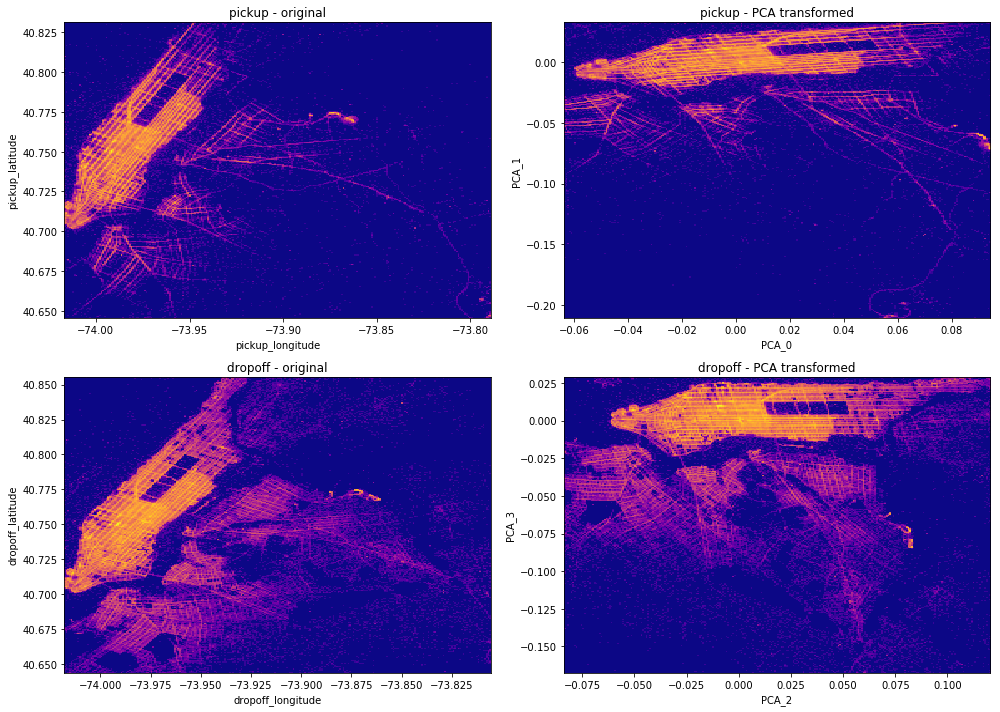

In [15]:
p.figure(figsize=(14, 10))

p.subplot(221)
p.title('pickup - original')
train.plot(train.pickup_longitude, train.pickup_latitude,
           colormap='plasma', f='log1p', shape=256, colorbar=False)

p.subplot(222)
p.title('pickup - PCA transformed')
train.plot(train.PCA_0, train.PCA_1,
           colormap='plasma', f='log1p', shape=256, colorbar=False)

p.subplot(223)
p.title('dropoff - original')
train.plot(train.dropoff_longitude, train.dropoff_latitude,
           colormap='plasma', f='log1p', shape=256, colorbar=False)

p.subplot(224)
p.title('dropoff - PCA transformed')
train.plot(train.PCA_2, train.PCA_3,
           colormap='plasma', f='log1p', shape=256, colorbar=False)



p.tight_layout()
p.show()

In [16]:
# inspect the vendor_id column
display(train.vendor_id.value_counts())

# Label encode vendor (support for one-hot, frequency-encoder)
le = vaex.ml.LabelEncoder(features=['vendor_id'])
train = le.fit_transform(train)

CMT    2378870
VTS    1071035
dtype: int64

In [17]:
# view the training set 
train.head(5)

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration_min,pu_hour,pu_day_of_week,pu_is_weekend,arc_distance_miles,direction_angle,PCA_0,PCA_1,PCA_2,PCA_3,label_encoded_vendor_id
0,VTS,2013-01-01 12:26:00.000000000,2013-01-01 12:37:00.000000000,1,2.49,-73.9717,40.7463,1,nan,-73.9785,40.7764,CRD,10.5,0,0.5,2.1,0,13.1,11,12,1,0,0.742002,-12.7022,0.00168645,-0.00933723,0.0196324,0.0151142,1
1,VTS,2013-01-01 12:31:00.000000000,2013-01-01 12:36:00.000000000,1,0.92,-73.9809,40.7643,1,nan,-73.9683,40.7625,CSH,5.5,0,0.5,0,0,6,5,12,1,0,0.869533,98.1237,0.00821217,0.00983361,0.0145178,-0.00132677,1
2,VTS,2013-01-01 11:39:00.000000000,2013-01-01 11:44:00.000000000,1,1.88,-73.9834,40.747,1,nan,-73.9667,40.77,CSH,7.5,0,0.5,0,0,8,5,11,1,0,1.23482,36.022,-0.00595342,-0.000428052,0.0214697,0.00182727,1
3,VTS,2013-01-01 11:15:00.000000000,2013-01-01 11:27:00.000000000,4,2.79,-73.9769,40.7542,1,nan,-73.9913,40.7504,CSH,11.5,0,0.5,0,0,12,12,11,1,0,0.999748,-104.629,0.00370112,-0.000105041,-0.0089249,0.0100284,1
4,VTS,2013-01-01 11:26:00.000000000,2013-01-01 11:30:00.000000000,3,0.86,-73.9534,40.7796,1,nan,-73.9563,40.7724,CSH,5.5,0,0.5,0,0,6,4,11,1,0,0.245737,-157.837,0.0383194,0.000825551,0.0295195,-0.00512802,1


### Setting up the predictor

In [18]:
# training features
features = ['passenger_count', 'trip_distance', 'rate_code', 'pu_hour', 'pu_day_of_week', 'pu_is_weekend', 
            'arc_distance_miles', 'direction_angle', 'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'label_encoded_vendor_id']

# target to predict
target = 'trip_duration_min'

In [19]:
# Use lightgbm (vaex.ml also supports xgboost, catboost, scikit-learn, annoy)
import vaex.ml.lightgbm

params = {
    'learning_rate': 0.1,       
    'max_depth': 7,             
    'colsample_bytree': 0.5,    
    'subsample': 0.8,           
    'reg_lambda': 1,            
    'reg_alpha': 0,             
    'min_child_weight': 1,      
    'objective': 'regression',  
    'random_state': 42,         
    'n_jobs': -1} 

# Instantiate the model object
booster = vaex.ml.lightgbm.LightGBMModel(features=features, params=params, num_boost_round=100)
# Fit the model object
booster.fit(train, target=target)

print('Training completed!')

/Users/jovan/miniconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in less


Training completed!


### Evaluate on the training set

In [20]:
# Classical predict - get an in-memory array of predictions
pred = booster.predict(train)

# view the predictions
display(pred)

# Create a virtual column housing the predictions
train_pred  = booster.transform(train)

# view the DataFrame
train_pred

array([13.28838425,  7.05198929,  9.34838095, ..., 12.1328571 ,
        7.55282688,  8.16310128])

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration_min,pu_hour,pu_day_of_week,pu_is_weekend,arc_distance_miles,direction_angle,PCA_0,PCA_1,PCA_2,PCA_3,label_encoded_vendor_id,lightgbm_prediction
0,VTS,2013-01-01 12:26:00.000000000,2013-01-01 12:37:00.000000000,1,2.49,-73.97171799999998,40.746267,1.0,nan,-73.97851,40.7764,CRD,10.5,0.0,0.5,2.1,0.0,13.1,11.0,12,1,0,0.7420023267151935,-12.702235048461684,0.001686452852996084,-0.009337225280007855,0.019632426208150762,0.015114156362343431,1,13.288384251659597
1,VTS,2013-01-01 12:31:00.000000000,2013-01-01 12:36:00.000000000,1,0.92,-73.98088,40.764327,1.0,nan,-73.968305,40.762532,CSH,5.5,0.0,0.5,0.0,0.0,6.0,5.0,12,1,0,0.8695325815244243,98.12372339855443,0.008212170794639687,0.00983360801816614,0.014517806041024133,-0.0013267715173738539,1,7.051989287037478
2,VTS,2013-01-01 11:39:00.000000000,2013-01-01 11:44:00.000000000,1,1.88,-73.98343,40.747022,1.0,nan,-73.966722,40.77,CSH,7.5,0.0,0.5,0.0,0.0,8.0,5.0,11,1,0,1.234820837876867,36.02203557291624,-0.005953416315164516,-0.00042805202466113376,0.021469707457457958,0.0018272702858079092,1,9.34838094701289
3,VTS,2013-01-01 11:15:00.000000000,2013-01-01 11:27:00.000000000,4,2.79,-73.976918,40.754157,1.0,nan,-73.99134999999998,40.75039,CSH,11.5,0.0,0.5,0.0,0.0,12.0,12.0,11,1,0,0.9997483980055442,-104.62879272563167,0.0037011180059170895,-0.00010504112230633146,-0.008924897612591435,0.010028396222816583,1,13.941531908367839
4,VTS,2013-01-01 11:26:00.000000000,2013-01-01 11:30:00.000000000,3,0.86,-73.953405,40.779582,1.0,nan,-73.956348,40.772357,CSH,5.5,0.0,0.5,0.0,0.0,6.0,4.0,11,1,0,0.24573666063889416,-157.83718087812204,0.038319404982068414,0.000825550537057386,0.029519505025092475,-0.005128021521159133,1,4.223363718609499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"3,449,900",VTS,2013-01-18 07:36:00.000000000,2013-01-18 07:42:00.000000000,3,1.5,-73.943662,40.629132,1.0,nan,-73.926017,40.637185,CSH,7.5,0.0,0.5,0.0,0.0,8.0,6.0,7,4,0,1.2288502300774,65.46852229283341,-0.0625471606741958,-0.11122829581241128,-0.061332732678210974,-0.10970961669594079,1,7.310093638190201
"3,449,901",VTS,2013-01-18 07:39:00.000000000,2013-01-18 07:43:00.000000000,1,1.06,-73.97114,40.79306,1.0,nan,-73.96255499999998,40.804802,CSH,5.0,0.0,0.5,0.0,0.0,5.5,4.0,7,4,0,0.6340853925233276,36.17188533587007,0.035578180249919114,0.022931486300283892,0.051963013339813895,0.01911025004524791,1,3.5083860232118713
"3,449,902",VTS,2013-01-18 07:33:00.000000000,2013-01-18 07:44:00.000000000,1,2.97,-74.008342,40.72158,1.0,nan,-73.98457,40.754392,CRD,11.0,0.0,0.5,1.5,0.0,13.0,11.0,7,4,0,1.7574107275505844,35.922992938811426,-0.0415609949569299,-0.00036930451045272955,-0.0016818693226994317,0.006942469264588013,1,12.132857104838575
"3,449,903",VTS,2013-01-18 07:35:00.000000000,2013-01-18 07:43:00.000000000,4,1.49,-73.98299199999998,40.75916,1.0,nan,-73.994737,40.76052,CSH,7.0,0.0,0.5,0.0,0.0,7.5,8.0,7,4,0,0.811923938222037,-83.39491114691047,0.0030392221879938157,0.007736220187332655,-0.002776880302890316,0.018762842522363446,1,7.552826880360384


In [21]:
# Check the performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_train_score = mean_absolute_error(train.trip_duration_min.values, pred)
mse_train_score = mean_squared_error(train.trip_duration_min.values, pred)

print('The mean absolute error is %2.3f' % mae_train_score)
print('The mean squared score is %2.3f' % mse_train_score)

The mean absolute error is 2.246
The mean squared score is 12.649


<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in less


## The `vaex` state - all the pipeline you need!

In [22]:
# serialize all the expressions used so far: filters, transformers, models.
train_pred.state_write('./data/vaex_model_pipeline.json')

### End of part 3